In [1]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

import tensorflow as tf

In [2]:
# read in 2018 songs
songs_df = pd.read_csv('data/songs_10000.csv')
songs_df.head()

,Unnamed: 0,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,90,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,1,Lil Baby,Drip Too Hard (Lil Baby & Gunna),78QR3Wp35dqAhFEc2qAGjE,86,0.08520,0.897,145543,0.662,0.000000,1,0.5340,-6.903,0,0.2920,112.511,4,0.389
2,2,Travis Scott,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,89,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446
3,3,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,88,0.34900,0.511,239836,0.566,0.000000,6,0.3400,-7.230,0,0.2000,83.903,4,0.218
4,4,YNW Melly,Murder On My Mind,7eBqSVxrzQZtK2mmgRG6lC,86,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740


In [ ]:
# drop additional index column
songs_df = songs_df.drop(columns = 'Unnamed: 0')

# calculate summary statistics
display(songs_df.describe())

# print out variable types
print(songs_df.dtypes)

In [ ]:
# matrix of pairwise scatterplots
scatter_matrix(songs_df, alpha = 0.8, figsize = (30, 20), diagonal = 'kde')

In [5]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)

In [22]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [23]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

KeyboardInterrupt: 

In [9]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 3
Classification accuracy on training set: 0.645
Classification accuracy on test set: 0.6395


In [24]:
cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [26]:
X_test

,Key,Time Signature,Mode,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence
5760,2,4,1,0.002126,0.299492,0.256368,0.716427,0.000002,0.231333,0.850080,0.073395,0.394990,0.246939
5683,2,4,1,0.832329,0.492386,0.225507,0.619231,0.000004,0.155933,0.813003,0.065942,0.591706,0.465306
7125,6,1,1,0.210842,0.576650,0.267664,0.302591,0.000000,0.086815,0.821384,0.029089,0.378979,0.218367
8092,2,4,1,0.527107,0.390863,0.346355,0.362713,0.000120,0.076553,0.794274,0.036128,0.538967,0.188776
5228,8,4,1,0.262047,0.748223,0.348043,0.724443,0.000097,0.066918,0.864429,0.051760,0.524237,0.666327
4715,2,4,1,0.000569,0.616244,0.250428,0.744484,0.000010,0.188397,0.884700,0.038923,0.581293,0.767347
645,11,4,1,0.051303,0.982741,0.351473,0.590172,0.000000,0.054456,0.821585,0.263975,0.590611,0.273469
4600,4,4,0,0.052307,0.627411,0.200290,0.561113,0.938000,0.195727,0.712118,0.025466,0.454586,0.121429
6146,0,4,1,0.795180,0.356345,0.378925,0.290567,0.000000,0.304639,0.809695,0.030642,0.653706,0.343878
7682,5,3,0,0.000010,0.237563,0.253184,0.928856,0.000039,0.097288,0.864920,0.448240,0.595200,0.283673


In [32]:
# specify network layers
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 1s 95us/sample - loss: 0.6562 - accuracy: 0.6414 - val_loss: 0.6504 - val_accuracy: 0.6454
Epoch 2/1000
5600/5600 [==============================] - 0s 40us/sample - loss: 0.6534 - accuracy: 0.6416 - val_loss: 0.6483 - val_accuracy: 0.6454
Epoch 3/1000
5600/5600 [==============================] - 0s 42us/sample - loss: 0.6495 - accuracy: 0.6416 - val_loss: 0.6501 - val_accuracy: 0.6454
Epoch 4/1000
5600/5600 [==============================] - 0s 37us/sample - loss: 0.6518 - accuracy: 0.6409 - val_loss: 0.6433 - val_accuracy: 0.6454
Epoch 5/1000
5600/5600 [==============================] - 0s 39us/sample - loss: 0.6441 - accuracy: 0.6420 - val_loss: 0.6436 - val_accuracy: 0.6446
Epoch 6/1000
5600/5600 [==============================] - 0s 36us/sample - loss: 0.6461 - accuracy: 0.6414 - val_loss: 0.6497 - val_accuracy: 0.6442
Epoch 7/1000
5600/5600 [==============================] - 

5600/5600 [==============================] - 0s 31us/sample - loss: 0.6059 - accuracy: 0.6577 - val_loss: 0.6537 - val_accuracy: 0.6304
Epoch 55/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.6048 - accuracy: 0.6646 - val_loss: 0.6602 - val_accuracy: 0.6233
Epoch 56/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6042 - accuracy: 0.6587 - val_loss: 0.6627 - val_accuracy: 0.6304
Epoch 57/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6051 - accuracy: 0.6536 - val_loss: 0.6586 - val_accuracy: 0.6375
Epoch 58/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6014 - accuracy: 0.6605 - val_loss: 0.6655 - val_accuracy: 0.6292
Epoch 59/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6029 - accuracy: 0.6591 - val_loss: 0.6615 - val_accuracy: 0.6096
Epoch 60/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6022 - accuracy: 0.6627 - val_

5600/5600 [==============================] - 0s 30us/sample - loss: 0.5446 - accuracy: 0.6934 - val_loss: 0.7450 - val_accuracy: 0.6208
Epoch 109/1000
5600/5600 [==============================] - 0s 34us/sample - loss: 0.5410 - accuracy: 0.7054 - val_loss: 0.7483 - val_accuracy: 0.6167
Epoch 110/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.5445 - accuracy: 0.7027 - val_loss: 0.7545 - val_accuracy: 0.6400
Epoch 111/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.5441 - accuracy: 0.7068 - val_loss: 0.7428 - val_accuracy: 0.6150
Epoch 112/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.5410 - accuracy: 0.7055 - val_loss: 0.7522 - val_accuracy: 0.6146
Epoch 113/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.5419 - accuracy: 0.7054 - val_loss: 0.7487 - val_accuracy: 0.6217
Epoch 114/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.5381 - accuracy: 0.7027 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.4695 - accuracy: 0.7527 - val_loss: 0.8732 - val_accuracy: 0.6079
Epoch 163/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.4670 - accuracy: 0.7564 - val_loss: 0.8851 - val_accuracy: 0.6092
Epoch 164/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.4581 - accuracy: 0.7659 - val_loss: 0.8759 - val_accuracy: 0.6029
Epoch 165/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.4587 - accuracy: 0.7650 - val_loss: 0.8811 - val_accuracy: 0.6154
Epoch 166/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.4587 - accuracy: 0.7634 - val_loss: 0.8858 - val_accuracy: 0.6058
Epoch 167/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.4550 - accuracy: 0.7623 - val_loss: 0.8952 - val_accuracy: 0.6125
Epoch 168/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.4631 - accuracy: 0.7596 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.4007 - accuracy: 0.8000 - val_loss: 1.0812 - val_accuracy: 0.6204
Epoch 217/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.3894 - accuracy: 0.8080 - val_loss: 1.0480 - val_accuracy: 0.6046
Epoch 218/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.3838 - accuracy: 0.8091 - val_loss: 1.0520 - val_accuracy: 0.5967
Epoch 219/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.3914 - accuracy: 0.8032 - val_loss: 1.0569 - val_accuracy: 0.5962
Epoch 220/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.3874 - accuracy: 0.8091 - val_loss: 1.1049 - val_accuracy: 0.6229
Epoch 221/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.3917 - accuracy: 0.8086 - val_loss: 1.0373 - val_accuracy: 0.5875
Epoch 222/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.3877 - accuracy: 0.8075 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.3311 - accuracy: 0.8413 - val_loss: 1.2221 - val_accuracy: 0.5950
Epoch 271/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.3260 - accuracy: 0.8445 - val_loss: 1.2499 - val_accuracy: 0.6133
Epoch 272/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.3310 - accuracy: 0.8402 - val_loss: 1.2221 - val_accuracy: 0.5925
Epoch 273/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.3218 - accuracy: 0.8516 - val_loss: 1.2725 - val_accuracy: 0.6108
Epoch 274/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.3307 - accuracy: 0.8411 - val_loss: 1.2344 - val_accuracy: 0.5983
Epoch 275/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.3166 - accuracy: 0.8468 - val_loss: 1.2395 - val_accuracy: 0.5971
Epoch 276/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.3223 - accuracy: 0.8461 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.2969 - accuracy: 0.8682 - val_loss: 1.3997 - val_accuracy: 0.5975
Epoch 325/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2980 - accuracy: 0.8661 - val_loss: 1.3621 - val_accuracy: 0.6004
Epoch 326/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2977 - accuracy: 0.8673 - val_loss: 1.4366 - val_accuracy: 0.5917
Epoch 327/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2971 - accuracy: 0.8623 - val_loss: 1.4126 - val_accuracy: 0.5958
Epoch 328/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2815 - accuracy: 0.8716 - val_loss: 1.3848 - val_accuracy: 0.5996
Epoch 329/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2781 - accuracy: 0.8750 - val_loss: 1.3796 - val_accuracy: 0.5925
Epoch 330/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.2727 - accuracy: 0.8795 

5600/5600 [==============================] - 0s 29us/sample - loss: 0.2459 - accuracy: 0.8943 - val_loss: 1.5752 - val_accuracy: 0.5971
Epoch 379/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2605 - accuracy: 0.8913 - val_loss: 1.5995 - val_accuracy: 0.6017
Epoch 380/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2671 - accuracy: 0.8775 - val_loss: 1.5472 - val_accuracy: 0.5875
Epoch 381/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2704 - accuracy: 0.8802 - val_loss: 1.5842 - val_accuracy: 0.5854
Epoch 382/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2624 - accuracy: 0.8841 - val_loss: 1.5542 - val_accuracy: 0.6021
Epoch 383/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2398 - accuracy: 0.8893 - val_loss: 1.6563 - val_accuracy: 0.6008
Epoch 384/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2497 - accuracy: 0.8889 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.2020 - accuracy: 0.9179 - val_loss: 1.7168 - val_accuracy: 0.6017
Epoch 433/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2060 - accuracy: 0.9086 - val_loss: 1.7330 - val_accuracy: 0.5896
Epoch 434/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2080 - accuracy: 0.9107 - val_loss: 1.7497 - val_accuracy: 0.6046
Epoch 435/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2071 - accuracy: 0.9155 - val_loss: 1.7525 - val_accuracy: 0.6108
Epoch 436/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.2126 - accuracy: 0.9054 - val_loss: 1.7771 - val_accuracy: 0.6037
Epoch 437/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2129 - accuracy: 0.9075 - val_loss: 1.7081 - val_accuracy: 0.5925
Epoch 438/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2044 - accuracy: 0.9150 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.1961 - accuracy: 0.9212 - val_loss: 1.9004 - val_accuracy: 0.5954
Epoch 487/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1909 - accuracy: 0.9202 - val_loss: 1.8783 - val_accuracy: 0.5996
Epoch 488/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1875 - accuracy: 0.9221 - val_loss: 1.8900 - val_accuracy: 0.5871
Epoch 489/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1849 - accuracy: 0.9230 - val_loss: 1.8602 - val_accuracy: 0.5879
Epoch 490/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1798 - accuracy: 0.9246 - val_loss: 1.8699 - val_accuracy: 0.5917
Epoch 491/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1741 - accuracy: 0.9314 - val_loss: 1.9322 - val_accuracy: 0.6100
Epoch 492/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1771 - accuracy: 0.9300 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.1919 - accuracy: 0.9196 - val_loss: 2.0205 - val_accuracy: 0.5858
Epoch 541/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1661 - accuracy: 0.9336 - val_loss: 2.0570 - val_accuracy: 0.5946
Epoch 542/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1576 - accuracy: 0.9423 - val_loss: 2.0440 - val_accuracy: 0.5933
Epoch 543/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1679 - accuracy: 0.9359 - val_loss: 2.0463 - val_accuracy: 0.5983
Epoch 544/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1579 - accuracy: 0.9438 - val_loss: 2.0495 - val_accuracy: 0.5954
Epoch 545/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1608 - accuracy: 0.9391 - val_loss: 2.0091 - val_accuracy: 0.5854
Epoch 546/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1517 - accuracy: 0.9448 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.1285 - accuracy: 0.9541 - val_loss: 2.1851 - val_accuracy: 0.6004
Epoch 595/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1415 - accuracy: 0.9450 - val_loss: 2.1685 - val_accuracy: 0.5883
Epoch 596/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1359 - accuracy: 0.9466 - val_loss: 2.2002 - val_accuracy: 0.5971
Epoch 597/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1274 - accuracy: 0.9550 - val_loss: 2.1687 - val_accuracy: 0.5896
Epoch 598/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1274 - accuracy: 0.9543 - val_loss: 2.2175 - val_accuracy: 0.5975
Epoch 599/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1383 - accuracy: 0.9463 - val_loss: 2.2065 - val_accuracy: 0.5962
Epoch 600/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1249 - accuracy: 0.9564 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.1134 - accuracy: 0.9614 - val_loss: 2.2850 - val_accuracy: 0.5875
Epoch 649/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1218 - accuracy: 0.9548 - val_loss: 2.4299 - val_accuracy: 0.6083
Epoch 650/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1212 - accuracy: 0.9541 - val_loss: 2.3165 - val_accuracy: 0.5962
Epoch 651/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1185 - accuracy: 0.9598 - val_loss: 2.3632 - val_accuracy: 0.5933
Epoch 652/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1125 - accuracy: 0.9614 - val_loss: 2.3492 - val_accuracy: 0.5913
Epoch 653/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1224 - accuracy: 0.9554 - val_loss: 2.3856 - val_accuracy: 0.6042
Epoch 654/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1155 - accuracy: 0.9575 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.1066 - accuracy: 0.9625 - val_loss: 2.4142 - val_accuracy: 0.5871
Epoch 703/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1007 - accuracy: 0.9659 - val_loss: 2.4335 - val_accuracy: 0.5821
Epoch 704/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0992 - accuracy: 0.9645 - val_loss: 2.4448 - val_accuracy: 0.5846
Epoch 705/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.0986 - accuracy: 0.9689 - val_loss: 2.4323 - val_accuracy: 0.5929
Epoch 706/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.0971 - accuracy: 0.9668 - val_loss: 2.4185 - val_accuracy: 0.5950
Epoch 707/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.0964 - accuracy: 0.9686 - val_loss: 2.4332 - val_accuracy: 0.5867
Epoch 708/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1056 - accuracy: 0.9614 

5600/5600 [==============================] - 0s 29us/sample - loss: 0.0961 - accuracy: 0.9663 - val_loss: 2.5134 - val_accuracy: 0.5904
Epoch 757/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0979 - accuracy: 0.9679 - val_loss: 2.5005 - val_accuracy: 0.5850
Epoch 758/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1182 - accuracy: 0.9577 - val_loss: 2.4831 - val_accuracy: 0.6021
Epoch 759/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0979 - accuracy: 0.9652 - val_loss: 2.5630 - val_accuracy: 0.5888
Epoch 760/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.0943 - accuracy: 0.9673 - val_loss: 2.5506 - val_accuracy: 0.5863
Epoch 761/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0991 - accuracy: 0.9695 - val_loss: 2.5057 - val_accuracy: 0.5904
Epoch 762/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0935 - accuracy: 0.9688 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.0865 - accuracy: 0.9704 - val_loss: 2.6646 - val_accuracy: 0.5863
Epoch 811/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1080 - accuracy: 0.9616 - val_loss: 2.7014 - val_accuracy: 0.6012
Epoch 812/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1416 - accuracy: 0.9493 - val_loss: 2.6993 - val_accuracy: 0.6062
Epoch 813/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1146 - accuracy: 0.9630 - val_loss: 2.6655 - val_accuracy: 0.5992
Epoch 814/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.1169 - accuracy: 0.9593 - val_loss: 2.6321 - val_accuracy: 0.5863
Epoch 815/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1037 - accuracy: 0.9595 - val_loss: 2.6445 - val_accuracy: 0.5858
Epoch 816/1000
5600/5600 [==============================] - 0s 34us/sample - loss: 0.0881 - accuracy: 0.9727 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.0707 - accuracy: 0.9771 - val_loss: 2.7220 - val_accuracy: 0.5913
Epoch 865/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.0725 - accuracy: 0.9771 - val_loss: 2.7486 - val_accuracy: 0.5729
Epoch 866/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.0757 - accuracy: 0.9761 - val_loss: 2.7133 - val_accuracy: 0.5896
Epoch 867/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0643 - accuracy: 0.9802 - val_loss: 2.7338 - val_accuracy: 0.5933
Epoch 868/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.0645 - accuracy: 0.9796 - val_loss: 2.7227 - val_accuracy: 0.5925
Epoch 869/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.0724 - accuracy: 0.9732 - val_loss: 2.7199 - val_accuracy: 0.5929
Epoch 870/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.0649 - accuracy: 0.9816 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.0656 - accuracy: 0.9777 - val_loss: 2.7935 - val_accuracy: 0.5942
Epoch 919/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0588 - accuracy: 0.9809 - val_loss: 2.7996 - val_accuracy: 0.5938
Epoch 920/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.0625 - accuracy: 0.9814 - val_loss: 2.8334 - val_accuracy: 0.5842
Epoch 921/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0612 - accuracy: 0.9814 - val_loss: 2.8098 - val_accuracy: 0.5888
Epoch 922/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0644 - accuracy: 0.9787 - val_loss: 2.8052 - val_accuracy: 0.5946
Epoch 923/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.0595 - accuracy: 0.9804 - val_loss: 2.8082 - val_accuracy: 0.5842
Epoch 924/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0673 - accuracy: 0.9793 

5600/5600 [==============================] - 0s 29us/sample - loss: 0.0648 - accuracy: 0.9802 - val_loss: 2.9248 - val_accuracy: 0.5746
Epoch 973/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0619 - accuracy: 0.9796 - val_loss: 2.8927 - val_accuracy: 0.5938
Epoch 974/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0602 - accuracy: 0.9816 - val_loss: 2.9062 - val_accuracy: 0.5858
Epoch 975/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.0568 - accuracy: 0.9850 - val_loss: 2.8897 - val_accuracy: 0.5892
Epoch 976/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0502 - accuracy: 0.9859 - val_loss: 2.9288 - val_accuracy: 0.5850
Epoch 977/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0570 - accuracy: 0.9830 - val_loss: 2.9122 - val_accuracy: 0.5967
Epoch 978/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.0541 - accuracy: 0.9834 

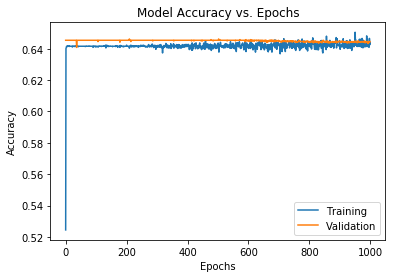

In [53]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [52]:
# specify network layers
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 0s 65us/sample - loss: 0.7570 - accuracy: 0.5245 - val_loss: 0.6523 - val_accuracy: 0.6454
Epoch 2/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.6573 - accuracy: 0.6402 - val_loss: 0.6477 - val_accuracy: 0.6454
Epoch 3/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.6531 - accuracy: 0.6407 - val_loss: 0.6456 - val_accuracy: 0.6454
Epoch 4/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.6518 - accuracy: 0.6416 - val_loss: 0.6441 - val_accuracy: 0.6454
Epoch 5/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6508 - accuracy: 0.6414 - val_loss: 0.6438 - val_accuracy: 0.6454
Epoch 6/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.6501 - accuracy: 0.6414 - val_loss: 0.6424 - val_accuracy: 0.6454
Epoch 7/1000
5600/5600 [==============================] - 

5600/5600 [==============================] - 0s 22us/sample - loss: 0.6468 - accuracy: 0.6416 - val_loss: 0.6428 - val_accuracy: 0.6454
Epoch 56/1000
5600/5600 [==============================] - 0s 22us/sample - loss: 0.6461 - accuracy: 0.6416 - val_loss: 0.6397 - val_accuracy: 0.6454
Epoch 57/1000
5600/5600 [==============================] - 0s 40us/sample - loss: 0.6457 - accuracy: 0.6416 - val_loss: 0.6396 - val_accuracy: 0.6454
Epoch 58/1000
5600/5600 [==============================] - 0s 54us/sample - loss: 0.6458 - accuracy: 0.6416 - val_loss: 0.6401 - val_accuracy: 0.6454
Epoch 59/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6465 - accuracy: 0.6416 - val_loss: 0.6408 - val_accuracy: 0.6454
Epoch 60/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6469 - accuracy: 0.6416 - val_loss: 0.6393 - val_accuracy: 0.6454
Epoch 61/1000
5600/5600 [==============================] - 0s 39us/sample - loss: 0.6455 - accuracy: 0.6416 - val_

5600/5600 [==============================] - 0s 20us/sample - loss: 0.6459 - accuracy: 0.6416 - val_loss: 0.6382 - val_accuracy: 0.6454
Epoch 110/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6451 - accuracy: 0.6416 - val_loss: 0.6388 - val_accuracy: 0.6454
Epoch 111/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6443 - accuracy: 0.6418 - val_loss: 0.6401 - val_accuracy: 0.6454
Epoch 112/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6468 - accuracy: 0.6416 - val_loss: 0.6391 - val_accuracy: 0.6454
Epoch 113/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6453 - accuracy: 0.6416 - val_loss: 0.6387 - val_accuracy: 0.6454
Epoch 114/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.6445 - accuracy: 0.6418 - val_loss: 0.6382 - val_accuracy: 0.6454
Epoch 115/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.6441 - accuracy: 0.6416 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.6422 - accuracy: 0.6416 - val_loss: 0.6375 - val_accuracy: 0.6454
Epoch 164/1000
5600/5600 [==============================] - 0s 21us/sample - loss: 0.6426 - accuracy: 0.6414 - val_loss: 0.6375 - val_accuracy: 0.6454
Epoch 165/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.6450 - accuracy: 0.6418 - val_loss: 0.6392 - val_accuracy: 0.6454
Epoch 166/1000
5600/5600 [==============================] - 0s 22us/sample - loss: 0.6445 - accuracy: 0.6414 - val_loss: 0.6373 - val_accuracy: 0.6454
Epoch 167/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6439 - accuracy: 0.6418 - val_loss: 0.6378 - val_accuracy: 0.6454
Epoch 168/1000
5600/5600 [==============================] - 0s 24us/sample - loss: 0.6460 - accuracy: 0.6416 - val_loss: 0.6372 - val_accuracy: 0.6454
Epoch 169/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.6435 - accuracy: 0.6420 

5600/5600 [==============================] - 0s 20us/sample - loss: 0.6415 - accuracy: 0.6413 - val_loss: 0.6359 - val_accuracy: 0.6454
Epoch 218/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6426 - accuracy: 0.6416 - val_loss: 0.6366 - val_accuracy: 0.6454
Epoch 219/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6411 - accuracy: 0.6418 - val_loss: 0.6370 - val_accuracy: 0.6454
Epoch 220/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6417 - accuracy: 0.6418 - val_loss: 0.6365 - val_accuracy: 0.6454
Epoch 221/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6442 - accuracy: 0.6414 - val_loss: 0.6361 - val_accuracy: 0.6454
Epoch 222/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6428 - accuracy: 0.6420 - val_loss: 0.6366 - val_accuracy: 0.6454
Epoch 223/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6421 - accuracy: 0.6413 

5600/5600 [==============================] - 0s 26us/sample - loss: 0.6425 - accuracy: 0.6416 - val_loss: 0.6346 - val_accuracy: 0.6454
Epoch 272/1000
5600/5600 [==============================] - 0s 21us/sample - loss: 0.6400 - accuracy: 0.6418 - val_loss: 0.6349 - val_accuracy: 0.6454
Epoch 273/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.6401 - accuracy: 0.6427 - val_loss: 0.6354 - val_accuracy: 0.6454
Epoch 274/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.6379 - accuracy: 0.6421 - val_loss: 0.6337 - val_accuracy: 0.6454
Epoch 275/1000
5600/5600 [==============================] - 0s 22us/sample - loss: 0.6378 - accuracy: 0.6418 - val_loss: 0.6336 - val_accuracy: 0.6454
Epoch 276/1000
5600/5600 [==============================] - 0s 21us/sample - loss: 0.6394 - accuracy: 0.6414 - val_loss: 0.6342 - val_accuracy: 0.6454
Epoch 277/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.6394 - accuracy: 0.6411 

5600/5600 [==============================] - 0s 34us/sample - loss: 0.6384 - accuracy: 0.6413 - val_loss: 0.6344 - val_accuracy: 0.6454
Epoch 326/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.6389 - accuracy: 0.6413 - val_loss: 0.6350 - val_accuracy: 0.6454
Epoch 327/1000
5600/5600 [==============================] - 0s 21us/sample - loss: 0.6380 - accuracy: 0.6420 - val_loss: 0.6347 - val_accuracy: 0.6454
Epoch 328/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6374 - accuracy: 0.6418 - val_loss: 0.6338 - val_accuracy: 0.6454
Epoch 329/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6405 - accuracy: 0.6418 - val_loss: 0.6338 - val_accuracy: 0.6454
Epoch 330/1000
5600/5600 [==============================] - 0s 21us/sample - loss: 0.6391 - accuracy: 0.6434 - val_loss: 0.6339 - val_accuracy: 0.6454
Epoch 331/1000
5600/5600 [==============================] - 0s 24us/sample - loss: 0.6398 - accuracy: 0.6432 

5600/5600 [==============================] - 0s 32us/sample - loss: 0.6379 - accuracy: 0.6405 - val_loss: 0.6336 - val_accuracy: 0.6454
Epoch 380/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.6389 - accuracy: 0.6407 - val_loss: 0.6345 - val_accuracy: 0.6454
Epoch 381/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.6390 - accuracy: 0.6405 - val_loss: 0.6334 - val_accuracy: 0.6454
Epoch 382/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.6358 - accuracy: 0.6414 - val_loss: 0.6333 - val_accuracy: 0.6454
Epoch 383/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.6382 - accuracy: 0.6414 - val_loss: 0.6335 - val_accuracy: 0.6454
Epoch 384/1000
5600/5600 [==============================] - 0s 36us/sample - loss: 0.6370 - accuracy: 0.6427 - val_loss: 0.6348 - val_accuracy: 0.6454
Epoch 385/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.6392 - accuracy: 0.6411 

5600/5600 [==============================] - 0s 62us/sample - loss: 0.6365 - accuracy: 0.6420 - val_loss: 0.6324 - val_accuracy: 0.6454
Epoch 434/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.6399 - accuracy: 0.6400 - val_loss: 0.6357 - val_accuracy: 0.6454
Epoch 435/1000
5600/5600 [==============================] - 0s 42us/sample - loss: 0.6384 - accuracy: 0.6416 - val_loss: 0.6352 - val_accuracy: 0.6454
Epoch 436/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.6359 - accuracy: 0.6413 - val_loss: 0.6365 - val_accuracy: 0.6454
Epoch 437/1000
5600/5600 [==============================] - 0s 24us/sample - loss: 0.6404 - accuracy: 0.6402 - val_loss: 0.6340 - val_accuracy: 0.6454
Epoch 438/1000
5600/5600 [==============================] - 0s 46us/sample - loss: 0.6365 - accuracy: 0.6421 - val_loss: 0.6341 - val_accuracy: 0.6454
Epoch 439/1000
5600/5600 [==============================] - 0s 47us/sample - loss: 0.6366 - accuracy: 0.6418 

5600/5600 [==============================] - 0s 28us/sample - loss: 0.6366 - accuracy: 0.6407 - val_loss: 0.6352 - val_accuracy: 0.6454
Epoch 488/1000
5600/5600 [==============================] - 0s 22us/sample - loss: 0.6346 - accuracy: 0.6416 - val_loss: 0.6326 - val_accuracy: 0.6454
Epoch 489/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6390 - accuracy: 0.6416 - val_loss: 0.6350 - val_accuracy: 0.6454
Epoch 490/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6361 - accuracy: 0.6434 - val_loss: 0.6342 - val_accuracy: 0.6454
Epoch 491/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.6388 - accuracy: 0.6405 - val_loss: 0.6341 - val_accuracy: 0.6454
Epoch 492/1000
5600/5600 [==============================] - 0s 20us/sample - loss: 0.6375 - accuracy: 0.6416 - val_loss: 0.6329 - val_accuracy: 0.6454
Epoch 493/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6365 - accuracy: 0.6427 

5600/5600 [==============================] - 0s 17us/sample - loss: 0.6349 - accuracy: 0.6421 - val_loss: 0.6356 - val_accuracy: 0.6454
Epoch 542/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6351 - accuracy: 0.6445 - val_loss: 0.6337 - val_accuracy: 0.6454
Epoch 543/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6335 - accuracy: 0.6404 - val_loss: 0.6363 - val_accuracy: 0.6454
Epoch 544/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6361 - accuracy: 0.6420 - val_loss: 0.6337 - val_accuracy: 0.6454
Epoch 545/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6342 - accuracy: 0.6404 - val_loss: 0.6336 - val_accuracy: 0.6454
Epoch 546/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6381 - accuracy: 0.6405 - val_loss: 0.6361 - val_accuracy: 0.6454
Epoch 547/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6360 - accuracy: 0.6407 

5600/5600 [==============================] - 0s 16us/sample - loss: 0.6360 - accuracy: 0.6438 - val_loss: 0.6339 - val_accuracy: 0.6450
Epoch 596/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6346 - accuracy: 0.6430 - val_loss: 0.6354 - val_accuracy: 0.6450
Epoch 597/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6351 - accuracy: 0.6420 - val_loss: 0.6378 - val_accuracy: 0.6450
Epoch 598/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6343 - accuracy: 0.6411 - val_loss: 0.6372 - val_accuracy: 0.6454
Epoch 599/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6364 - accuracy: 0.6420 - val_loss: 0.6358 - val_accuracy: 0.6454
Epoch 600/1000
5600/5600 [==============================] - 0s 19us/sample - loss: 0.6352 - accuracy: 0.6421 - val_loss: 0.6350 - val_accuracy: 0.6454
Epoch 601/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6367 - accuracy: 0.6402 

5600/5600 [==============================] - 0s 19us/sample - loss: 0.6320 - accuracy: 0.6421 - val_loss: 0.6325 - val_accuracy: 0.6454
Epoch 650/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6347 - accuracy: 0.6411 - val_loss: 0.6363 - val_accuracy: 0.6450
Epoch 651/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6340 - accuracy: 0.6405 - val_loss: 0.6334 - val_accuracy: 0.6450
Epoch 652/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6322 - accuracy: 0.6429 - val_loss: 0.6332 - val_accuracy: 0.6446
Epoch 653/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6341 - accuracy: 0.6393 - val_loss: 0.6350 - val_accuracy: 0.6450
Epoch 654/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6355 - accuracy: 0.6398 - val_loss: 0.6359 - val_accuracy: 0.6454
Epoch 655/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6351 - accuracy: 0.6436 

5600/5600 [==============================] - 0s 18us/sample - loss: 0.6352 - accuracy: 0.6421 - val_loss: 0.6403 - val_accuracy: 0.6450
Epoch 704/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6354 - accuracy: 0.6418 - val_loss: 0.6359 - val_accuracy: 0.6450
Epoch 705/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6364 - accuracy: 0.6368 - val_loss: 0.6337 - val_accuracy: 0.6446
Epoch 706/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6336 - accuracy: 0.6411 - val_loss: 0.6335 - val_accuracy: 0.6446
Epoch 707/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6328 - accuracy: 0.6436 - val_loss: 0.6361 - val_accuracy: 0.6446
Epoch 708/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6329 - accuracy: 0.6420 - val_loss: 0.6336 - val_accuracy: 0.6446
Epoch 709/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6337 - accuracy: 0.6402 

5600/5600 [==============================] - 0s 16us/sample - loss: 0.6320 - accuracy: 0.6411 - val_loss: 0.6332 - val_accuracy: 0.6446
Epoch 758/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6341 - accuracy: 0.6425 - val_loss: 0.6360 - val_accuracy: 0.6442
Epoch 759/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6326 - accuracy: 0.6446 - val_loss: 0.6344 - val_accuracy: 0.6446
Epoch 760/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6347 - accuracy: 0.6429 - val_loss: 0.6357 - val_accuracy: 0.6442
Epoch 761/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6360 - accuracy: 0.6434 - val_loss: 0.6353 - val_accuracy: 0.6442
Epoch 762/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6337 - accuracy: 0.6420 - val_loss: 0.6334 - val_accuracy: 0.6442
Epoch 763/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6308 - accuracy: 0.6414 

5600/5600 [==============================] - 0s 19us/sample - loss: 0.6322 - accuracy: 0.6441 - val_loss: 0.6322 - val_accuracy: 0.6442
Epoch 812/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6345 - accuracy: 0.6470 - val_loss: 0.6417 - val_accuracy: 0.6450
Epoch 813/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6325 - accuracy: 0.6429 - val_loss: 0.6353 - val_accuracy: 0.6446
Epoch 814/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6340 - accuracy: 0.6432 - val_loss: 0.6340 - val_accuracy: 0.6438
Epoch 815/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6331 - accuracy: 0.6438 - val_loss: 0.6360 - val_accuracy: 0.6446
Epoch 816/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6337 - accuracy: 0.6434 - val_loss: 0.6458 - val_accuracy: 0.6450
Epoch 817/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6337 - accuracy: 0.6413 

5600/5600 [==============================] - 0s 21us/sample - loss: 0.6322 - accuracy: 0.6416 - val_loss: 0.6353 - val_accuracy: 0.6442
Epoch 866/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6313 - accuracy: 0.6432 - val_loss: 0.6356 - val_accuracy: 0.6438
Epoch 867/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6345 - accuracy: 0.6423 - val_loss: 0.6325 - val_accuracy: 0.6438
Epoch 868/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6328 - accuracy: 0.6454 - val_loss: 0.6341 - val_accuracy: 0.6438
Epoch 869/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6322 - accuracy: 0.6432 - val_loss: 0.6409 - val_accuracy: 0.6446
Epoch 870/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6325 - accuracy: 0.6409 - val_loss: 0.6375 - val_accuracy: 0.6442
Epoch 871/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6363 - accuracy: 0.6418 

5600/5600 [==============================] - 0s 16us/sample - loss: 0.6323 - accuracy: 0.6427 - val_loss: 0.6420 - val_accuracy: 0.6446
Epoch 920/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6307 - accuracy: 0.6423 - val_loss: 0.6350 - val_accuracy: 0.6442
Epoch 921/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6311 - accuracy: 0.6407 - val_loss: 0.6381 - val_accuracy: 0.6446
Epoch 922/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6330 - accuracy: 0.6450 - val_loss: 0.6436 - val_accuracy: 0.6446
Epoch 923/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6312 - accuracy: 0.6413 - val_loss: 0.6324 - val_accuracy: 0.6446
Epoch 924/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6309 - accuracy: 0.6452 - val_loss: 0.6397 - val_accuracy: 0.6438
Epoch 925/1000
5600/5600 [==============================] - 0s 18us/sample - loss: 0.6300 - accuracy: 0.6434 

5600/5600 [==============================] - 0s 16us/sample - loss: 0.6324 - accuracy: 0.6425 - val_loss: 0.6441 - val_accuracy: 0.6446
Epoch 974/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6299 - accuracy: 0.6466 - val_loss: 0.6362 - val_accuracy: 0.6446
Epoch 975/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6339 - accuracy: 0.6407 - val_loss: 0.6394 - val_accuracy: 0.6446
Epoch 976/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6282 - accuracy: 0.6457 - val_loss: 0.6408 - val_accuracy: 0.6446
Epoch 977/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6312 - accuracy: 0.6438 - val_loss: 0.6381 - val_accuracy: 0.6442
Epoch 978/1000
5600/5600 [==============================] - 0s 17us/sample - loss: 0.6311 - accuracy: 0.6407 - val_loss: 0.6396 - val_accuracy: 0.6446
Epoch 979/1000
5600/5600 [==============================] - 0s 16us/sample - loss: 0.6309 - accuracy: 0.6425 

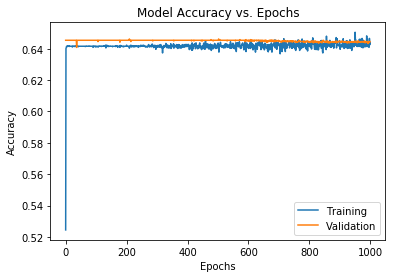

In [54]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [67]:
songs_df = pd.read_csv('data/songs_10000.csv')

# drop additional index column
songs_df = songs_df.drop(columns = 'Unnamed: 0')

songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean.Popularity, test_size = 0.2, 
                                                    random_state = 100)

In [68]:
# cat_cols = ['Key', 'Time Signature']
# X_train_num = X_train.drop(cat_cols, axis = 1)
# X_test_num = X_test.drop(cat_cols, axis = 1)
# num_features = X_train_num.columns.tolist()
# num_index_train = X_train.index.tolist()
# num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

# scaler = MinMaxScaler().fit(X_train_num)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

# X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
# X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [69]:
X_test

,Key,Time Signature,Mode,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence
8018,11,4,0,0.010138,0.800000,0.239920,0.485962,0.000524,0.009589,0.833175,0.265010,0.568203,0.432074
9225,6,4,1,0.724899,0.680203,0.105684,0.462915,0.000009,0.061393,0.821867,0.283644,0.430502,0.222676
3854,11,4,1,0.764056,0.626396,0.301020,0.248482,0.599000,0.098395,0.670088,0.039130,0.735592,0.632278
2029,1,4,1,0.045681,0.829442,0.268965,0.665324,0.000000,0.048676,0.825085,0.059627,0.445949,0.208376
3539,11,4,1,0.462850,0.948223,0.246726,0.565122,0.000018,0.084845,0.901042,0.066046,0.522910,0.554648
1942,11,4,0,0.027909,0.626396,0.270068,0.733462,0.000000,0.109860,0.857285,0.028778,0.386085,0.738509
1250,1,4,1,0.000739,0.788832,0.296175,0.658310,0.000003,0.076715,0.864151,0.245342,0.863212,0.250255
2817,1,4,0,0.086243,0.817259,0.360517,0.834666,0.000000,0.039817,0.857444,0.124224,0.495577,0.718080
4211,2,4,1,0.099195,0.786802,0.193043,0.659312,0.000000,0.095268,0.893950,0.181159,0.635977,0.331971
477,1,4,1,0.066263,0.890355,0.296823,0.559109,0.000000,0.057223,0.899003,0.354037,0.713438,0.503575


In [81]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 1s 114us/sample - loss: 1087.3272 - mean_squared_error: 1087.3274 - val_loss: 64.0599 - val_mean_squared_error: 64.0599
Epoch 2/1000
5600/5600 [==============================] - 0s 86us/sample - loss: 65.0369 - mean_squared_error: 65.0369 - val_loss: 60.3037 - val_mean_squared_error: 60.3037
Epoch 3/1000
5600/5600 [==============================] - 0s 81us/sample - loss: 62.3946 - mean_squared_error: 62.3946 - val_loss: 59.2946 - val_mean_squared_error: 59.2946
Epoch 4/1000
5600/5600 [==============================] - 0s 86us/sample - loss: 61.6495 - mean_squared_error: 61.6495 - val_loss: 58.6100 - val_mean_squared_error: 58.6100
Epoch 5/1000
5600/5600 [==============================] - 1s 89us/sample - loss: 61.2329 - mean_squared_error: 61.2329 - val_loss: 58.2909 - val_mean_squared_error: 58.2909
Epoch 6/1000
5600/5600 [==============================] - 1s 95us/sample - loss: 6

Epoch 48/1000
5600/5600 [==============================] - 1s 138us/sample - loss: 59.5451 - mean_squared_error: 59.5451 - val_loss: 58.1125 - val_mean_squared_error: 58.1125
Epoch 49/1000
5600/5600 [==============================] - 1s 145us/sample - loss: 59.4567 - mean_squared_error: 59.4567 - val_loss: 56.6045 - val_mean_squared_error: 56.6045
Epoch 50/1000
5600/5600 [==============================] - 1s 176us/sample - loss: 59.5434 - mean_squared_error: 59.5434 - val_loss: 57.3567 - val_mean_squared_error: 57.3567
Epoch 51/1000
5600/5600 [==============================] - 1s 147us/sample - loss: 59.3023 - mean_squared_error: 59.3023 - val_loss: 57.1210 - val_mean_squared_error: 57.1210
Epoch 52/1000
5600/5600 [==============================] - 1s 113us/sample - loss: 59.6055 - mean_squared_error: 59.6055 - val_loss: 57.0171 - val_mean_squared_error: 57.0171
Epoch 53/1000
5600/5600 [==============================] - 1s 107us/sample - loss: 59.4689 - mean_squared_error: 59.4689 - va

5600/5600 [==============================] - 1s 112us/sample - loss: 59.1945 - mean_squared_error: 59.1945 - val_loss: 56.5264 - val_mean_squared_error: 56.5264
Epoch 95/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 59.1774 - mean_squared_error: 59.1774 - val_loss: 57.0434 - val_mean_squared_error: 57.0434
Epoch 96/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 59.5983 - mean_squared_error: 59.5983 - val_loss: 57.6252 - val_mean_squared_error: 57.6252
Epoch 97/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 59.5601 - mean_squared_error: 59.5601 - val_loss: 56.9291 - val_mean_squared_error: 56.9291
Epoch 98/1000
5600/5600 [==============================] - 1s 93us/sample - loss: 59.3148 - mean_squared_error: 59.3148 - val_loss: 58.3983 - val_mean_squared_error: 58.3984
Epoch 99/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 59.3688 - mean_squared_error: 59.3688 - val_loss: 57.5287 - v

Epoch 141/1000
5600/5600 [==============================] - 0s 84us/sample - loss: 59.1223 - mean_squared_error: 59.1223 - val_loss: 56.6651 - val_mean_squared_error: 56.6651
Epoch 142/1000
5600/5600 [==============================] - 1s 93us/sample - loss: 58.8696 - mean_squared_error: 58.8696 - val_loss: 56.0590 - val_mean_squared_error: 56.0590
Epoch 143/1000
5600/5600 [==============================] - 0s 76us/sample - loss: 58.7457 - mean_squared_error: 58.7457 - val_loss: 56.1363 - val_mean_squared_error: 56.1363
Epoch 144/1000
5600/5600 [==============================] - 1s 103us/sample - loss: 58.8101 - mean_squared_error: 58.8101 - val_loss: 56.6538 - val_mean_squared_error: 56.6538
Epoch 145/1000
5600/5600 [==============================] - 1s 105us/sample - loss: 58.8631 - mean_squared_error: 58.8631 - val_loss: 57.2484 - val_mean_squared_error: 57.2484
Epoch 146/1000
5600/5600 [==============================] - 0s 76us/sample - loss: 58.9654 - mean_squared_error: 58.9654 - 

Epoch 188/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 58.2617 - mean_squared_error: 58.2617 - val_loss: 55.6124 - val_mean_squared_error: 55.6124
Epoch 189/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 58.5324 - mean_squared_error: 58.5324 - val_loss: 56.5411 - val_mean_squared_error: 56.5411
Epoch 190/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 58.5209 - mean_squared_error: 58.5209 - val_loss: 55.7365 - val_mean_squared_error: 55.7365
Epoch 191/1000
5600/5600 [==============================] - 0s 86us/sample - loss: 58.6057 - mean_squared_error: 58.6057 - val_loss: 55.6394 - val_mean_squared_error: 55.6394
Epoch 192/1000
5600/5600 [==============================] - 0s 72us/sample - loss: 58.5244 - mean_squared_error: 58.5244 - val_loss: 55.7592 - val_mean_squared_error: 55.7592
Epoch 193/1000
5600/5600 [==============================] - 0s 73us/sample - loss: 58.3998 - mean_squared_error: 58.3998 - va

Epoch 235/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 57.9292 - mean_squared_error: 57.9292 - val_loss: 55.3581 - val_mean_squared_error: 55.3581
Epoch 236/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 57.9631 - mean_squared_error: 57.9631 - val_loss: 55.9113 - val_mean_squared_error: 55.9113
Epoch 237/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 58.1096 - mean_squared_error: 58.1096 - val_loss: 55.6972 - val_mean_squared_error: 55.6972
Epoch 238/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 58.2841 - mean_squared_error: 58.2841 - val_loss: 55.7615 - val_mean_squared_error: 55.7615
Epoch 239/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 57.7757 - mean_squared_error: 57.7757 - val_loss: 55.4557 - val_mean_squared_error: 55.4557
Epoch 240/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 58.0016 - mean_squared_error: 58.0016 - va

Epoch 282/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 57.8616 - mean_squared_error: 57.8616 - val_loss: 55.2306 - val_mean_squared_error: 55.2306
Epoch 283/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 57.9079 - mean_squared_error: 57.9079 - val_loss: 55.4501 - val_mean_squared_error: 55.4501
Epoch 284/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 57.7048 - mean_squared_error: 57.7048 - val_loss: 55.4064 - val_mean_squared_error: 55.4064
Epoch 285/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 57.9303 - mean_squared_error: 57.9303 - val_loss: 55.3633 - val_mean_squared_error: 55.3633
Epoch 286/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 57.6545 - mean_squared_error: 57.6545 - val_loss: 55.7425 - val_mean_squared_error: 55.7424
Epoch 287/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 57.7630 - mean_squared_error: 57.7630 - va

Epoch 329/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 57.9299 - mean_squared_error: 57.9299 - val_loss: 55.8250 - val_mean_squared_error: 55.8249
Epoch 330/1000
5600/5600 [==============================] - 0s 66us/sample - loss: 57.5148 - mean_squared_error: 57.5148 - val_loss: 55.3156 - val_mean_squared_error: 55.3156
Epoch 331/1000
5600/5600 [==============================] - 0s 75us/sample - loss: 57.6433 - mean_squared_error: 57.6433 - val_loss: 55.2460 - val_mean_squared_error: 55.2460
Epoch 332/1000
5600/5600 [==============================] - 0s 77us/sample - loss: 57.6399 - mean_squared_error: 57.6398 - val_loss: 55.2691 - val_mean_squared_error: 55.2691
Epoch 333/1000
5600/5600 [==============================] - 0s 73us/sample - loss: 57.5623 - mean_squared_error: 57.5623 - val_loss: 55.6560 - val_mean_squared_error: 55.6560
Epoch 334/1000
5600/5600 [==============================] - 0s 80us/sample - loss: 57.7643 - mean_squared_error: 57.7643 - va

Epoch 376/1000
5600/5600 [==============================] - 0s 84us/sample - loss: 57.4209 - mean_squared_error: 57.4209 - val_loss: 57.3944 - val_mean_squared_error: 57.3944
Epoch 377/1000
5600/5600 [==============================] - 0s 80us/sample - loss: 57.4597 - mean_squared_error: 57.4597 - val_loss: 55.0191 - val_mean_squared_error: 55.0191
Epoch 378/1000
5600/5600 [==============================] - 1s 91us/sample - loss: 57.7274 - mean_squared_error: 57.7274 - val_loss: 56.4136 - val_mean_squared_error: 56.4136
Epoch 379/1000
5600/5600 [==============================] - 0s 86us/sample - loss: 57.3296 - mean_squared_error: 57.3296 - val_loss: 55.0241 - val_mean_squared_error: 55.0241
Epoch 380/1000
5600/5600 [==============================] - 0s 84us/sample - loss: 57.4486 - mean_squared_error: 57.4486 - val_loss: 55.0495 - val_mean_squared_error: 55.0495
Epoch 381/1000
5600/5600 [==============================] - 0s 84us/sample - loss: 57.5915 - mean_squared_error: 57.5915 - va

Epoch 423/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 57.7060 - mean_squared_error: 57.7060 - val_loss: 57.9237 - val_mean_squared_error: 57.9237
Epoch 424/1000
5600/5600 [==============================] - 0s 85us/sample - loss: 57.3172 - mean_squared_error: 57.3172 - val_loss: 57.5966 - val_mean_squared_error: 57.5966
Epoch 425/1000
5600/5600 [==============================] - 0s 70us/sample - loss: 57.5006 - mean_squared_error: 57.5006 - val_loss: 55.0006 - val_mean_squared_error: 55.0005
Epoch 426/1000
5600/5600 [==============================] - 1s 91us/sample - loss: 57.4969 - mean_squared_error: 57.4969 - val_loss: 55.0195 - val_mean_squared_error: 55.0195
Epoch 427/1000
5600/5600 [==============================] - 0s 76us/sample - loss: 57.2946 - mean_squared_error: 57.2946 - val_loss: 56.5771 - val_mean_squared_error: 56.5771
Epoch 428/1000
5600/5600 [==============================] - 0s 77us/sample - loss: 57.4157 - mean_squared_error: 57.4157 - va

Epoch 470/1000
5600/5600 [==============================] - 0s 66us/sample - loss: 57.1560 - mean_squared_error: 57.1560 - val_loss: 55.2184 - val_mean_squared_error: 55.2184
Epoch 471/1000
5600/5600 [==============================] - 0s 67us/sample - loss: 57.0713 - mean_squared_error: 57.0713 - val_loss: 54.9836 - val_mean_squared_error: 54.9836
Epoch 472/1000
5600/5600 [==============================] - 0s 69us/sample - loss: 56.9340 - mean_squared_error: 56.9340 - val_loss: 55.0961 - val_mean_squared_error: 55.0961
Epoch 473/1000
5600/5600 [==============================] - 0s 69us/sample - loss: 57.1482 - mean_squared_error: 57.1482 - val_loss: 55.5379 - val_mean_squared_error: 55.5379
Epoch 474/1000
5600/5600 [==============================] - 0s 70us/sample - loss: 57.1898 - mean_squared_error: 57.1898 - val_loss: 55.1277 - val_mean_squared_error: 55.1277
Epoch 475/1000
5600/5600 [==============================] - 0s 68us/sample - loss: 56.9087 - mean_squared_error: 56.9087 - va

Epoch 517/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 56.7900 - mean_squared_error: 56.7900 - val_loss: 55.0361 - val_mean_squared_error: 55.0361
Epoch 518/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 57.0563 - mean_squared_error: 57.0563 - val_loss: 55.0837 - val_mean_squared_error: 55.0837
Epoch 519/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 56.8942 - mean_squared_error: 56.8942 - val_loss: 55.0330 - val_mean_squared_error: 55.0330
Epoch 520/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 57.2604 - mean_squared_error: 57.2604 - val_loss: 54.8664 - val_mean_squared_error: 54.8664
Epoch 521/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 56.8569 - mean_squared_error: 56.8569 - val_loss: 54.9699 - val_mean_squared_error: 54.9699
Epoch 522/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 56.8565 - mean_squared_error: 56.8565 - va

Epoch 564/1000
5600/5600 [==============================] - 0s 81us/sample - loss: 56.8436 - mean_squared_error: 56.8437 - val_loss: 54.9924 - val_mean_squared_error: 54.9924
Epoch 565/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 56.6368 - mean_squared_error: 56.6368 - val_loss: 54.9619 - val_mean_squared_error: 54.9619
Epoch 566/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 56.6723 - mean_squared_error: 56.6723 - val_loss: 55.3110 - val_mean_squared_error: 55.3110
Epoch 567/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 56.4998 - mean_squared_error: 56.4997 - val_loss: 55.0994 - val_mean_squared_error: 55.0994
Epoch 568/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 56.7254 - mean_squared_error: 56.7254 - val_loss: 55.5912 - val_mean_squared_error: 55.5912
Epoch 569/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 56.5402 - mean_squared_error: 56.5402 - va

Epoch 611/1000
5600/5600 [==============================] - 0s 76us/sample - loss: 56.4164 - mean_squared_error: 56.4164 - val_loss: 55.7387 - val_mean_squared_error: 55.7387
Epoch 612/1000
5600/5600 [==============================] - 1s 92us/sample - loss: 56.6000 - mean_squared_error: 56.6000 - val_loss: 55.0260 - val_mean_squared_error: 55.0260
Epoch 613/1000
5600/5600 [==============================] - 1s 109us/sample - loss: 56.6299 - mean_squared_error: 56.6299 - val_loss: 55.4363 - val_mean_squared_error: 55.4363
Epoch 614/1000
5600/5600 [==============================] - 0s 83us/sample - loss: 56.3944 - mean_squared_error: 56.3944 - val_loss: 55.3768 - val_mean_squared_error: 55.3768
Epoch 615/1000
5600/5600 [==============================] - 0s 67us/sample - loss: 56.4909 - mean_squared_error: 56.4909 - val_loss: 55.2601 - val_mean_squared_error: 55.2601
Epoch 616/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 56.4112 - mean_squared_error: 56.4112 - v

Epoch 658/1000
5600/5600 [==============================] - 0s 69us/sample - loss: 56.6166 - mean_squared_error: 56.6166 - val_loss: 55.2178 - val_mean_squared_error: 55.2178
Epoch 659/1000
5600/5600 [==============================] - 0s 67us/sample - loss: 56.0921 - mean_squared_error: 56.0921 - val_loss: 55.2717 - val_mean_squared_error: 55.2717
Epoch 660/1000
5600/5600 [==============================] - 0s 68us/sample - loss: 56.0556 - mean_squared_error: 56.0556 - val_loss: 56.5824 - val_mean_squared_error: 56.5824
Epoch 661/1000
5600/5600 [==============================] - 0s 81us/sample - loss: 56.6157 - mean_squared_error: 56.6157 - val_loss: 55.2918 - val_mean_squared_error: 55.2918
Epoch 662/1000
5600/5600 [==============================] - 0s 77us/sample - loss: 56.2201 - mean_squared_error: 56.2201 - val_loss: 55.1469 - val_mean_squared_error: 55.1469
Epoch 663/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 56.3003 - mean_squared_error: 56.3003 - va

Epoch 705/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 56.0690 - mean_squared_error: 56.0690 - val_loss: 55.2310 - val_mean_squared_error: 55.2310
Epoch 706/1000
5600/5600 [==============================] - 0s 57us/sample - loss: 55.9800 - mean_squared_error: 55.9800 - val_loss: 55.1744 - val_mean_squared_error: 55.1744
Epoch 707/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 56.0153 - mean_squared_error: 56.0153 - val_loss: 55.9364 - val_mean_squared_error: 55.9364
Epoch 708/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 56.0925 - mean_squared_error: 56.0926 - val_loss: 56.2805 - val_mean_squared_error: 56.2805
Epoch 709/1000
5600/5600 [==============================] - 0s 65us/sample - loss: 56.1500 - mean_squared_error: 56.1500 - val_loss: 55.2365 - val_mean_squared_error: 55.2365
Epoch 710/1000
5600/5600 [==============================] - 1s 89us/sample - loss: 56.1037 - mean_squared_error: 56.1037 - va

Epoch 752/1000
5600/5600 [==============================] - 0s 78us/sample - loss: 55.8327 - mean_squared_error: 55.8327 - val_loss: 55.3748 - val_mean_squared_error: 55.3748
Epoch 753/1000
5600/5600 [==============================] - 0s 66us/sample - loss: 55.9640 - mean_squared_error: 55.9640 - val_loss: 55.4066 - val_mean_squared_error: 55.4066
Epoch 754/1000
5600/5600 [==============================] - 0s 69us/sample - loss: 55.9707 - mean_squared_error: 55.9706 - val_loss: 55.9169 - val_mean_squared_error: 55.9169
Epoch 755/1000
5600/5600 [==============================] - 0s 64us/sample - loss: 55.8414 - mean_squared_error: 55.8414 - val_loss: 55.4687 - val_mean_squared_error: 55.4687
Epoch 756/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.9273 - mean_squared_error: 55.9273 - val_loss: 55.2538 - val_mean_squared_error: 55.2538
Epoch 757/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.7349 - mean_squared_error: 55.7349 - va

Epoch 799/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 55.5847 - mean_squared_error: 55.5847 - val_loss: 55.3233 - val_mean_squared_error: 55.3233
Epoch 800/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 55.7581 - mean_squared_error: 55.7581 - val_loss: 55.9551 - val_mean_squared_error: 55.9551
Epoch 801/1000
5600/5600 [==============================] - 0s 59us/sample - loss: 55.7574 - mean_squared_error: 55.7574 - val_loss: 58.7651 - val_mean_squared_error: 58.7651
Epoch 802/1000
5600/5600 [==============================] - 1s 104us/sample - loss: 55.7684 - mean_squared_error: 55.7684 - val_loss: 55.5799 - val_mean_squared_error: 55.5799
Epoch 803/1000
5600/5600 [==============================] - 1s 116us/sample - loss: 55.7850 - mean_squared_error: 55.7850 - val_loss: 55.4217 - val_mean_squared_error: 55.4217
Epoch 804/1000
5600/5600 [==============================] - 1s 137us/sample - loss: 56.0715 - mean_squared_error: 56.0715 -

Epoch 846/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.6208 - mean_squared_error: 55.6208 - val_loss: 55.5324 - val_mean_squared_error: 55.5324
Epoch 847/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.7421 - mean_squared_error: 55.7421 - val_loss: 55.6852 - val_mean_squared_error: 55.6852
Epoch 848/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.5689 - mean_squared_error: 55.5688 - val_loss: 55.5550 - val_mean_squared_error: 55.5550
Epoch 849/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 55.5363 - mean_squared_error: 55.5363 - val_loss: 55.6681 - val_mean_squared_error: 55.6681
Epoch 850/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.6482 - mean_squared_error: 55.6482 - val_loss: 55.8272 - val_mean_squared_error: 55.8272
Epoch 851/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.6772 - mean_squared_error: 55.6772 - va

Epoch 893/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.3948 - mean_squared_error: 55.3948 - val_loss: 55.7574 - val_mean_squared_error: 55.7574
Epoch 894/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.3516 - mean_squared_error: 55.3516 - val_loss: 57.5355 - val_mean_squared_error: 57.5355
Epoch 895/1000
5600/5600 [==============================] - 0s 61us/sample - loss: 55.5477 - mean_squared_error: 55.5477 - val_loss: 55.8214 - val_mean_squared_error: 55.8214
Epoch 896/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.2723 - mean_squared_error: 55.2723 - val_loss: 55.6430 - val_mean_squared_error: 55.6430
Epoch 897/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.2528 - mean_squared_error: 55.2528 - val_loss: 57.6586 - val_mean_squared_error: 57.6586
Epoch 898/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.5013 - mean_squared_error: 55.5013 - va

Epoch 940/1000
5600/5600 [==============================] - 1s 100us/sample - loss: 55.3186 - mean_squared_error: 55.3187 - val_loss: 56.9179 - val_mean_squared_error: 56.9179
Epoch 941/1000
5600/5600 [==============================] - 1s 139us/sample - loss: 55.2092 - mean_squared_error: 55.2092 - val_loss: 57.1364 - val_mean_squared_error: 57.1364
Epoch 942/1000
5600/5600 [==============================] - 0s 88us/sample - loss: 55.2026 - mean_squared_error: 55.2026 - val_loss: 55.8503 - val_mean_squared_error: 55.8503
Epoch 943/1000
5600/5600 [==============================] - 0s 83us/sample - loss: 55.1727 - mean_squared_error: 55.1727 - val_loss: 56.7058 - val_mean_squared_error: 56.7058
Epoch 944/1000
5600/5600 [==============================] - 1s 94us/sample - loss: 55.4930 - mean_squared_error: 55.4930 - val_loss: 55.8251 - val_mean_squared_error: 55.8251
Epoch 945/1000
5600/5600 [==============================] - 0s 85us/sample - loss: 55.1626 - mean_squared_error: 55.1626 - 

Epoch 987/1000
5600/5600 [==============================] - 0s 62us/sample - loss: 55.3702 - mean_squared_error: 55.3702 - val_loss: 55.9742 - val_mean_squared_error: 55.9742
Epoch 988/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 54.8918 - mean_squared_error: 54.8918 - val_loss: 56.5696 - val_mean_squared_error: 56.5696
Epoch 989/1000
5600/5600 [==============================] - 0s 68us/sample - loss: 55.1011 - mean_squared_error: 55.1011 - val_loss: 56.1393 - val_mean_squared_error: 56.1393
Epoch 990/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.0721 - mean_squared_error: 55.0721 - val_loss: 55.8920 - val_mean_squared_error: 55.8920
Epoch 991/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 55.0316 - mean_squared_error: 55.0316 - val_loss: 56.5205 - val_mean_squared_error: 56.5205
Epoch 992/1000
5600/5600 [==============================] - 0s 60us/sample - loss: 55.4669 - mean_squared_error: 55.4669 - va

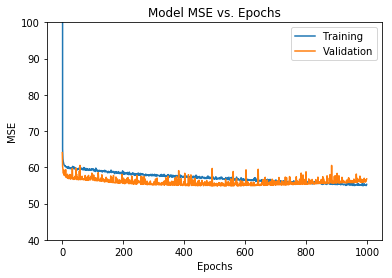

In [82]:
# plot training and validation accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE vs. Epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.ylim(bottom = 40)
plt.ylim(top = 100)
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()